Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 16.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 71.4 MB/s 
     |████████████████████████████████| 120 kB 89.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=ed0f57ca353a8b6ebb15f97a91d6caac1b41f8689c6e5e9ea8f0c25d9519d297
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1hIe1NaUcYENwTFrG_z1WUEiEkEzhtzbx'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fbR_cCVnnvMiJuaS7tvGE8nHHepciFuG'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1cz6lxw3dd-zeoKtLewT7pjSkIIh4BjOe'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  226
Number of dev sentences:  40
Number of test sentences:  48
Number of words in the training dataset:  5862
Number of words in the dev dataset:  1874
Number of words in the test dataset:  2030
Tags in the training dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'I-PARTY', 'I-DOC_NAME', 'B-PARTY', 'O', 'B-DOC_NAME']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'I-PARTY', 'I-DOC_NAME', 'B-PARTY', 'O', 'B-DOC_NAME']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-AGMT_DATE', 'I-AGMT_DATE', 'I-PARTY', 'I-DOC_NAME', 'B-PARTY', 'O', 'B-DOC_NAME']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Exhibit,O
1,Sentence: 1,99.1,O
2,Sentence: 1,JOINT,B-DOC_NAME
3,Sentence: 1,FILING,I-DOC_NAME
4,Sentence: 1,AGREEMENT,I-DOC_NAME
5,Sentence: 1,The,O
6,Sentence: 1,undersigned,O
7,Sentence: 1,hereby,O
8,Sentence: 1,agree,O
9,Sentence: 1,that,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Exhibit', 'O'),
 ('10.8', 'O'),
 ('Services', 'B-DOC_NAME'),
 ('Agreement', 'I-DOC_NAME'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('and', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 ('(', 'I-PARTY'),
 ('International', 'I-PARTY'),
 (')', 'I-PARTY'),
 ('Limited', 'I-PARTY'),
 ('September', 'O'),
 ('2018', 'O'),
 ('1', 'O'),
 ('THIS', 'O'),
 ('SERVICES', 'B-DOC_NAME'),
 ('AGREEMENT', 'I-DOC_NAME'),
 ('(', 'O'),
 ('this', 'O'),
 ('“', 'O'),
 ('Agreement', 'O'),
 ('”', 'O'),
 (')', 'O'),
 ('is', 'O'),
 ('made', 'O'),
 ('on', 'O'),
 ('25', 'B-AGMT_DATE'),
 ('September', 'I-AGMT_DATE'),
 ('2018', 'I-AGMT_DATE'),
 ('BETWEEN', 'O'),
 (':', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (')', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('a', 'O'),
 ('Delaware', 'O'),
 ('limited', 'O'),
 ('partnership', 'O

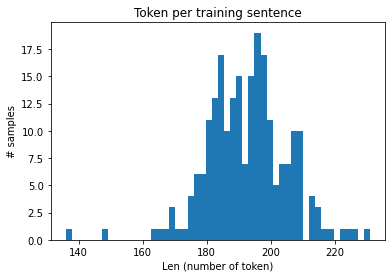

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

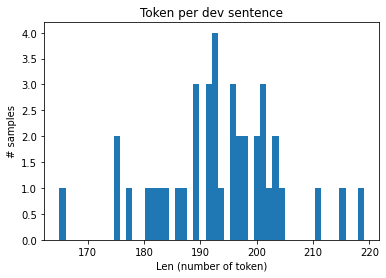

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

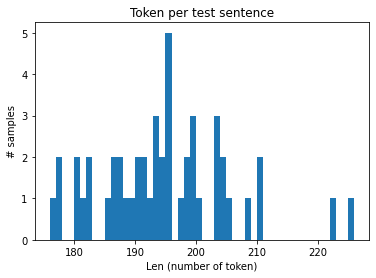

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'business'
print(word2idx['business'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-PARTY'
print(tag2idx['B-PARTY'])
# Tag of index 2
print(idx2tag[2])

583
Skype
4
I-PARTY


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.77876)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 226
Points in y_train before removal: 226
Points in X_train before removal: 50
Points in y_train before removal: 50


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[6652, 5083, 4208, 755, 7066, 7010, 3347, 4208, 755, 7066, 7010, 3583, 4598, 396, 4223, 396, 5534, 7106, 728, 4826, 6867, 4877, 5361, 6921, 3469, 3583, 4598, 396, 4074, 3096, 396, 5534, 6921, 1409, 3836, 1910, 4897, 3181, 6921, 4367, 4890, 6921, 4654, 7215, 2981, 6103, 4654, 3042, 6867, 583, 880, 705, 4636, 3403, 1303, 1037, 6921, 3088, 7136, 6921, 2990, 2290, 3583, 396, 3414, 396, 5534, 6921, 3836, 661, 6921, 4367, 4890, 6921, 4654, 7215, 2981, 6921, 6103, 5861, 1579, 3042, 6867, 583, 880, 6520, 3568, 6602, 1403, 6921, 1303, 1125, 6921, 4461, 6492, 6921, 435, 1079, 3583, 396, 2760, 396, 5534, 4890, 4648, 6921, 2760, 3556, 4654, 2434, 1268, 4598, 3732, 6921, 2029, 3699, 880, 6996, 3583, 4598, 396, 2760, 3656, 396, 5534, 6921, 2440, 844, 6105, 3856, 3836, 3872, 1268, 755, 4634, 4648, 6921, 3414, 3556, 310, 1268, 4598, 3732, 6921, 2029, 3699, 880, 5815, 3583, 4598, 396, 3414, 1526, 396, 5534, 6921, 2440, 844, 5998, 1268, 755, 6456, 158, 4441, 6500, 6921, 452, 4392, 6921, 6836, 6921, 4776

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.2 MB/s 
     |████████████████████████████████| 6.6 MB 75.0 MB/s 
     |████████████████████████████████| 120 kB 78.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=291040754b6340dc5ea05a505b5c2586c4663cee6e5098b03c3b0d90c012569d
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[6652, 5083, 4208, 755, 7066, 7010, 3347, 4208, 755, 7066,

In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [9]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0396971702575684
Training loss epoch: 0.9510215044021606
Training accuracy epoch: 0.7183432986590195
Validating model...
Validation Loss: 0.6167317479848862
Validation Accuracy: 0.8638646856275621
Training epoch: 2
Training loss per 100 training steps: 0.526310920715332
Training loss epoch: 0.47600053548812865
Training accuracy epoch: 0.8745162563779878
Validating model...
Validation Loss: 0.38995859026908875
Validation Accuracy: 0.8763930949587491
Training epoch: 3
Training loss per 100 training steps: 0.4365956783294678
Training loss epoch: 0.3329983353614807
Training accuracy epoch: 0.900282438663045
Validating model...
Validation Loss: 0.2614514157176018
Validation Accuracy: 0.9110501584616769
Training epoch: 4
Training loss per 100 training steps: 0.30953916907310486
Training loss epoch: 0.2241281896829605
Training accuracy epoch: 0.9266056820909541
Validating model...
Validation Loss: 0.18055207654833794
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09144562184810638
Validation Accuracy: 0.9779574486348579
Validation duration: 0.007668916666666684 minutes
F1-score (test): 78.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.75      0.84      0.79        82
       PARTY       0.69      0.81      0.74       122

   micro avg       0.74      0.83      0.78       254
   macro avg       0.76      0.84      0.80       254
weighted avg       0.74      0.83      0.78       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1286532878875732
Training loss epoch: 1.0246349573135376
Training accuracy epoch: 0.706475540298041
Validating model...
Validation Loss: 0.6427710950374603
Validation Accuracy: 0.8636273983089209
Training epoch: 2
Training loss per 100 training steps: 0.5755260586738586
Training loss epoch: 0.5577468037605285
Training accuracy epoch: 0.8741531268103702
Validating model...
Validation Loss: 0.5198045000433922
Validation Accuracy: 0.8635909070947058
Training epoch: 3
Training loss per 100 training steps: 0.5435048937797546
Training loss epoch: 0.4689639389514923
Training accuracy epoch: 0.8743931775397165
Validating model...
Validation Loss: 0.3954944312572479
Validation Accuracy: 0.8690373277141735
Training epoch: 4
Training loss per 100 training steps: 0.4024949371814728
Training loss epoch: 0.3463417887687683
Training accuracy epoch: 0.8889358279691777
Validating model...
Validation Loss: 0.2975109592080116
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09457626268267631
Validation Accuracy: 0.9752555820766522
Validation duration: 0.0076296333333334115 minutes
F1-score (test): 75.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.64      0.74      0.69        82
       PARTY       0.72      0.81      0.76       122

   micro avg       0.71      0.80      0.75       254
   macro avg       0.73      0.81      0.76       254
weighted avg       0.72      0.80      0.75       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.043691396713257
Training loss epoch: 0.950310206413269
Training accuracy epoch: 0.7183240000243204
Validating model...
Validation Loss: 0.5697959661483765
Validation Accuracy: 0.8636548327935107
Training epoch: 2
Training loss per 100 training steps: 0.5560998916625977
Training loss epoch: 0.5176531076431274
Training accuracy epoch: 0.874316831440443
Validating model...
Validation Loss: 0.4491238445043564
Validation Accuracy: 0.863639840736486
Training epoch: 3
Training loss per 100 training steps: 0.4042436182498932
Training loss epoch: 0.3770411789417267
Training accuracy epoch: 0.8810189367670208
Validating model...
Validation Loss: 0.29860348999500275
Validation Accuracy: 0.8966883419035844
Training epoch: 4
Training loss per 100 training steps: 0.23898310959339142
Training loss epoch: 0.2319457858800888
Training accuracy epoch: 0.9282955785435109
Validating model...
Validation Loss: 0.189013559371233
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11126319020986557
Validation Accuracy: 0.9705321687833475
Validation duration: 0.007790133333333197 minutes
F1-score (test): 74.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.84      0.82        50
    DOC_NAME       0.67      0.73      0.70        82
       PARTY       0.67      0.82      0.74       122

   micro avg       0.70      0.80      0.74       254
   macro avg       0.72      0.80      0.75       254
weighted avg       0.70      0.80      0.74       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.0527303218841553
Training loss epoch: 0.9839876413345336
Training accuracy epoch: 0.7175199909297338
Validating model...
Validation Loss: 0.6149522960186005
Validation Accuracy: 0.8636631631282716
Training epoch: 2
Training loss per 100 training steps: 0.5038707256317139
Training loss epoch: 0.4954774796962738
Training accuracy epoch: 0.8742315114236536
Validating model...
Validation Loss: 0.38926441967487335
Validation Accuracy: 0.869272521715046
Training epoch: 3
Training loss per 100 training steps: 0.4046694040298462
Training loss epoch: 0.3295493841171265
Training accuracy epoch: 0.9017858970240841
Validating model...
Validation Loss: 0.23657263815402985
Validation Accuracy: 0.9280072661069061
Training epoch: 4
Training loss per 100 training steps: 0.2497454434633255
Training loss epoch: 0.210670804977417
Training accuracy epoch: 0.9360382571110707
Validating model...
Validation Loss: 0.18980672955513
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0986721932888031
Validation Accuracy: 0.9745847536826551
Validation duration: 0.00767029999999996 minutes
F1-score (test): 77.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.88      0.85        50
    DOC_NAME       0.72      0.83      0.77        82
       PARTY       0.67      0.84      0.74       122

   micro avg       0.71      0.84      0.77       254
   macro avg       0.73      0.85      0.79       254
weighted avg       0.71      0.84      0.77       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8743857145309448
Training loss epoch: 0.9082782149314881
Training accuracy epoch: 0.7431289520631129
Validating model...
Validation Loss: 0.5713386535644531
Validation Accuracy: 0.8635100313367154
Training epoch: 2
Training loss per 100 training steps: 0.5308494567871094
Training loss epoch: 0.5275488197803497
Training accuracy epoch: 0.8744884264343092
Validating model...
Validation Loss: 0.4581831991672516
Validation Accuracy: 0.8635821635196554
Training epoch: 3
Training loss per 100 training steps: 0.4701594114303589
Training loss epoch: 0.3541425585746765
Training accuracy epoch: 0.8966444475063021
Validating model...
Validation Loss: 0.24846072494983673
Validation Accuracy: 0.925918947112936
Training epoch: 4
Training loss per 100 training steps: 0.2529118061065674
Training loss epoch: 0.20993192493915558
Training accuracy epoch: 0.9386043974027146
Validating model...
Validation Loss: 0.19891313463449478
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10705910623073578
Validation Accuracy: 0.9740887933109444
Validation duration: 0.007702666666666384 minutes
F1-score (test): 78.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.86      0.87        50
    DOC_NAME       0.71      0.83      0.76        82
       PARTY       0.71      0.84      0.77       122

   micro avg       0.74      0.84      0.79       254
   macro avg       0.77      0.84      0.80       254
weighted avg       0.74      0.84      0.79       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.0533535480499268
Training loss epoch: 0.9898220777511597
Training accuracy epoch: 0.7076742352111562
Validating model...
Validation Loss: 0.5773031190037727
Validation Accuracy: 0.8631861479786214
Training epoch: 2
Training loss per 100 training steps: 0.596581757068634
Training loss epoch: 0.523022323846817
Training accuracy epoch: 0.8738815598182897
Validating model...
Validation Loss: 0.42922748625278473
Validation Accuracy: 0.863364585414305
Training epoch: 3
Training loss per 100 training steps: 0.4646618664264679
Training loss epoch: 0.3557921200990677
Training accuracy epoch: 0.8886494539205095
Validating model...
Validation Loss: 0.2533636949956417
Validation Accuracy: 0.9255166625473679
Training epoch: 4
Training loss per 100 training steps: 0.1933010220527649
Training loss epoch: 0.22116739153862
Training accuracy epoch: 0.9319231520554073
Validating model...
Validation Loss: 0.1951872892677784
Validation Accuracy: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10437568575143814
Validation Accuracy: 0.9730909278028168
Validation duration: 0.008082166666666524 minutes
F1-score (test): 74.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.66      0.74      0.70        82
       PARTY       0.68      0.83      0.75       122

   micro avg       0.70      0.80      0.74       254
   macro avg       0.72      0.80      0.75       254
weighted avg       0.70      0.80      0.74       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8824275732040405
Training loss epoch: 0.8640817880630494
Training accuracy epoch: 0.7402795655509189
Validating model...
Validation Loss: 0.5031035915017128
Validation Accuracy: 0.862943385213919
Training epoch: 2
Training loss per 100 training steps: 0.4942714273929596
Training loss epoch: 0.4166098594665527
Training accuracy epoch: 0.8809484836843513
Validating model...
Validation Loss: 0.31520870327949524
Validation Accuracy: 0.8978342335497537
Training epoch: 3
Training loss per 100 training steps: 0.2895973324775696
Training loss epoch: 0.24308377802371978
Training accuracy epoch: 0.9242829234629155
Validating model...
Validation Loss: 0.1861465759575367
Validation Accuracy: 0.939472310650963
Training epoch: 4
Training loss per 100 training steps: 0.17972058057785034
Training loss epoch: 0.15369746088981628
Training accuracy epoch: 0.9472723328309212
Validating model...
Validation Loss: 0.15576763451099396
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09180236160755158
Validation Accuracy: 0.9799880124511505
Validation duration: 0.009160733333333344 minutes
F1-score (test): 80.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.78      0.87      0.82        82
       PARTY       0.73      0.84      0.78       122

   micro avg       0.77      0.85      0.81       254
   macro avg       0.78      0.86      0.82       254
weighted avg       0.77      0.85      0.81       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8412269353866577
Training loss epoch: 0.8502239346504211
Training accuracy epoch: 0.746377427552176
Validating model...
Validation Loss: 0.5067220255732536
Validation Accuracy: 0.8634861853913337
Training epoch: 2
Training loss per 100 training steps: 0.4728555679321289
Training loss epoch: 0.4120522737503052
Training accuracy epoch: 0.8878512748297382
Validating model...
Validation Loss: 0.30419958382844925
Validation Accuracy: 0.9030515199620957
Training epoch: 3
Training loss per 100 training steps: 0.2642019987106323
Training loss epoch: 0.24743974208831787
Training accuracy epoch: 0.9240338145481785
Validating model...
Validation Loss: 0.2000655047595501
Validation Accuracy: 0.931630992820071
Training epoch: 4
Training loss per 100 training steps: 0.1694827526807785
Training loss epoch: 0.1609987199306488
Training accuracy epoch: 0.9455203095555313
Validating model...
Validation Loss: 0.1676410734653473
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11355819702148437
Validation Accuracy: 0.9665250364738803
Validation duration: 0.007780316666667394 minutes
F1-score (test): 71.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.65      0.68      0.67        82
       PARTY       0.65      0.80      0.71       122

   micro avg       0.68      0.76      0.72       254
   macro avg       0.71      0.77      0.73       254
weighted avg       0.68      0.76      0.72       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1451587677001953
Training loss epoch: 1.0291165351867675
Training accuracy epoch: 0.7082382850406435
Validating model...
Validation Loss: 0.6396257728338242
Validation Accuracy: 0.8633241153726081
Training epoch: 2
Training loss per 100 training steps: 0.6396107077598572
Training loss epoch: 0.5243994772434235
Training accuracy epoch: 0.8742456185268134
Validating model...
Validation Loss: 0.43038323521614075
Validation Accuracy: 0.8664431340492835
Training epoch: 3
Training loss per 100 training steps: 0.44841891527175903
Training loss epoch: 0.36227635145187376
Training accuracy epoch: 0.8893945443954239
Validating model...
Validation Loss: 0.27917542308568954
Validation Accuracy: 0.9084894305165583
Training epoch: 4
Training loss per 100 training steps: 0.28262433409690857
Training loss epoch: 0.23688749670982362
Training accuracy epoch: 0.9287186018185306
Validating model...
Validation Loss: 0.18432753160595894
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10057766810059547
Validation Accuracy: 0.9776904321224343
Validation duration: 0.007779516666666571 minutes
F1-score (test): 77.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.80      0.81        50
    DOC_NAME       0.69      0.77      0.73        82
       PARTY       0.77      0.83      0.80       122

   micro avg       0.75      0.80      0.78       254
   macro avg       0.76      0.80      0.78       254
weighted avg       0.75      0.80      0.78       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1513917446136475
Training loss epoch: 1.029626977443695
Training accuracy epoch: 0.7089133229112494
Validating model...
Validation Loss: 0.6365686058998108
Validation Accuracy: 0.8635549650589072
Training epoch: 2
Training loss per 100 training steps: 0.5712668299674988
Training loss epoch: 0.5456794261932373
Training accuracy epoch: 0.8742059261040751
Validating model...
Validation Loss: 0.48742494732141495
Validation Accuracy: 0.8635277196243467
Training epoch: 3
Training loss per 100 training steps: 0.4336583614349365
Training loss epoch: 0.4247872233390808
Training accuracy epoch: 0.8751825087129014
Validating model...
Validation Loss: 0.3524204269051552
Validation Accuracy: 0.8902142275149352
Training epoch: 4
Training loss per 100 training steps: 0.33721229434013367
Training loss epoch: 0.30698763132095336
Training accuracy epoch: 0.9115621936382438
Validating model...
Validation Loss: 0.2425599992275238
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11004112511873246
Validation Accuracy: 0.9736457931322222
Validation duration: 0.007665333333333516 minutes
F1-score (test): 74.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.71      0.79      0.75        82
       PARTY       0.65      0.81      0.72       122

   micro avg       0.69      0.81      0.75       254
   macro avg       0.72      0.81      0.76       254
weighted avg       0.70      0.81      0.75       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.077946186065674
Training loss epoch: 0.8166133420807975
Training accuracy epoch: 0.7782578456647767
Validating model...
Validation Loss: 0.5852666646242142
Validation Accuracy: 0.8632597921960521
Training epoch: 2
Training loss per 100 training steps: 0.45286476612091064
Training loss epoch: 0.5152860369001117
Training accuracy epoch: 0.8833577966218441
Validating model...
Validation Loss: 0.48333797603845596
Validation Accuracy: 0.8636999872533023
Training epoch: 3
Training loss per 100 training steps: 0.39527657628059387
Training loss epoch: 0.38214159863335745
Training accuracy epoch: 0.8928322525096756
Validating model...
Validation Loss: 0.27438394352793694
Validation Accuracy: 0.9177229479107222
Training epoch: 4
Training loss per 100 training steps: 0.23317213356494904
Training loss epoch: 0.22529771498271398
Training accuracy epoch: 0.9306371151179782
Validating model...
Validation Loss: 0.2052484005689621
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11210300475358963
Validation Accuracy: 0.9742254231805738
Validation duration: 0.007717216666666597 minutes
F1-score (test): 76.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.66      0.74      0.70        82
       PARTY       0.73      0.83      0.78       122

   micro avg       0.72      0.80      0.76       254
   macro avg       0.74      0.80      0.77       254
weighted avg       0.73      0.80      0.76       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8483575582504272
Training loss epoch: 0.7255916510309491
Training accuracy epoch: 0.7993826112064426
Validating model...
Validation Loss: 0.4881225675344467
Validation Accuracy: 0.8635582452625943
Training epoch: 2
Training loss per 100 training steps: 0.4018935561180115
Training loss epoch: 0.345868855714798
Training accuracy epoch: 0.8993391613017315
Validating model...
Validation Loss: 0.24939750507473946
Validation Accuracy: 0.9189891145689129
Training epoch: 3
Training loss per 100 training steps: 0.2925069332122803
Training loss epoch: 0.2095902647290911
Training accuracy epoch: 0.9342337238989585
Validating model...
Validation Loss: 0.17609497159719467
Validation Accuracy: 0.939198595117837
Training epoch: 4
Training loss per 100 training steps: 0.15689118206501007
Training loss epoch: 0.14728771895170212
Training accuracy epoch: 0.9507809182220177
Validating model...
Validation Loss: 0.14838135801255703
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10383962094783783
Validation Accuracy: 0.9767835657119284
Validation duration: 0.007771349999999681 minutes
F1-score (test): 76.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.86      0.87        50
    DOC_NAME       0.74      0.80      0.77        82
       PARTY       0.64      0.80      0.71       122

   micro avg       0.71      0.81      0.76       254
   macro avg       0.75      0.82      0.78       254
weighted avg       0.72      0.81      0.76       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.981186866760254
Training loss epoch: 0.8113034239837101
Training accuracy epoch: 0.7757298780517156
Validating model...
Validation Loss: 0.5612195432186127
Validation Accuracy: 0.8639779633593099
Training epoch: 2
Training loss per 100 training steps: 0.511529803276062
Training loss epoch: 0.47233620285987854
Training accuracy epoch: 0.8784834159041325
Validating model...
Validation Loss: 0.39630863815546036
Validation Accuracy: 0.8638636853094039
Training epoch: 3
Training loss per 100 training steps: 0.35504329204559326
Training loss epoch: 0.3251443249838693
Training accuracy epoch: 0.8984001462002938
Validating model...
Validation Loss: 0.2520340122282505
Validation Accuracy: 0.9196437104871156
Training epoch: 4
Training loss per 100 training steps: 0.19270756840705872
Training loss epoch: 0.2189080672604697
Training accuracy epoch: 0.932768125465059
Validating model...
Validation Loss: 0.1929347962141037
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10559369772672653
Validation Accuracy: 0.9747660503622289
Validation duration: 0.009224516666666698 minutes
F1-score (test): 75.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.82      0.81        50
    DOC_NAME       0.70      0.79      0.74        82
       PARTY       0.69      0.79      0.74       122

   micro avg       0.71      0.80      0.75       254
   macro avg       0.73      0.80      0.76       254
weighted avg       0.72      0.80      0.75       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9491394758224487
Training loss epoch: 0.8108584071908679
Training accuracy epoch: 0.7851568005605183
Validating model...
Validation Loss: 0.5645570755004883
Validation Accuracy: 0.8634794605775503
Training epoch: 2
Training loss per 100 training steps: 0.5283852219581604
Training loss epoch: 0.4391820728778839
Training accuracy epoch: 0.8843913929666881
Validating model...
Validation Loss: 0.3729682043194771
Validation Accuracy: 0.8718466620247345
Training epoch: 3
Training loss per 100 training steps: 0.39209848642349243
Training loss epoch: 0.27240100290094105
Training accuracy epoch: 0.9151146610434014
Validating model...
Validation Loss: 0.19775104150176048
Validation Accuracy: 0.9330839283969271
Training epoch: 4
Training loss per 100 training steps: 0.18216675519943237
Training loss epoch: 0.16088597902229854
Training accuracy epoch: 0.9474409803616078
Validating model...
Validation Loss: 0.15157006308436394
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10090468302369118
Validation Accuracy: 0.976539588974133
Validation duration: 0.009268050000000017 minutes
F1-score (test): 76.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.77      0.80      0.78        50
    DOC_NAME       0.73      0.84      0.78        82
       PARTY       0.70      0.78      0.74       122

   micro avg       0.72      0.80      0.76       254
   macro avg       0.73      0.81      0.77       254
weighted avg       0.72      0.80      0.76       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9551808834075928
Training loss epoch: 0.8253729300839561
Training accuracy epoch: 0.7736007071307832
Validating model...
Validation Loss: 0.5910084694623947
Validation Accuracy: 0.8636123519392223
Training epoch: 2
Training loss per 100 training steps: 0.4772297441959381
Training loss epoch: 0.4692897243159158
Training accuracy epoch: 0.8853673271162289
Validating model...
Validation Loss: 0.4049745574593544
Validation Accuracy: 0.863737368175792
Training epoch: 3
Training loss per 100 training steps: 0.32158684730529785
Training loss epoch: 0.2949296534061432
Training accuracy epoch: 0.9088027875485333
Validating model...
Validation Loss: 0.22260857746005058
Validation Accuracy: 0.9279630743214169
Training epoch: 4
Training loss per 100 training steps: 0.2384929209947586
Training loss epoch: 0.17103400826454163
Training accuracy epoch: 0.9466783022982151
Validating model...
Validation Loss: 0.20873664319515228
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10637924671173096
Validation Accuracy: 0.9778526753252261
Validation duration: 0.009223816666667517 minutes
F1-score (test): 80.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.78      0.84      0.81        82
       PARTY       0.74      0.84      0.79       122

   micro avg       0.78      0.84      0.81       254
   macro avg       0.79      0.85      0.82       254
weighted avg       0.78      0.84      0.81       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1694083213806152
Training loss epoch: 0.8379777584757123
Training accuracy epoch: 0.764591041119277
Validating model...
Validation Loss: 0.58778515458107
Validation Accuracy: 0.8637432755479786
Training epoch: 2
Training loss per 100 training steps: 0.5397776961326599
Training loss epoch: 0.5224355246339526
Training accuracy epoch: 0.8845766228606227
Validating model...
Validation Loss: 0.5402185022830963
Validation Accuracy: 0.8632263953014824
Training epoch: 3
Training loss per 100 training steps: 0.514340341091156
Training loss epoch: 0.42474966815539766
Training accuracy epoch: 0.8867668257109181
Validating model...
Validation Loss: 0.33906421810388565
Validation Accuracy: 0.8962718757223191
Training epoch: 4
Training loss per 100 training steps: 0.33330589532852173
Training loss epoch: 0.26374305146081106
Training accuracy epoch: 0.9254006048347782
Validating model...
Validation Loss: 0.20707761868834496
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.099262635409832
Validation Accuracy: 0.9699676955877656
Validation duration: 0.009917966666665733 minutes
F1-score (test): 75.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.72      0.85      0.78        82
       PARTY       0.61      0.84      0.71       122

   micro avg       0.68      0.85      0.75       254
   macro avg       0.72      0.85      0.77       254
weighted avg       0.69      0.85      0.76       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9741334915161133
Training loss epoch: 0.7674830385616848
Training accuracy epoch: 0.7715024771028801
Validating model...
Validation Loss: 0.5031737759709358
Validation Accuracy: 0.8637642741330047
Training epoch: 2
Training loss per 100 training steps: 0.5117563605308533
Training loss epoch: 0.36931335074560984
Training accuracy epoch: 0.8933674353097304
Validating model...
Validation Loss: 0.272738803178072
Validation Accuracy: 0.915817476648072
Training epoch: 3
Training loss per 100 training steps: 0.2638554275035858
Training loss epoch: 0.20683839278561728
Training accuracy epoch: 0.9345569230129532
Validating model...
Validation Loss: 0.17447883635759354
Validation Accuracy: 0.9420034942304234
Training epoch: 4
Training loss per 100 training steps: 0.15516924858093262
Training loss epoch: 0.12420545837708882
Training accuracy epoch: 0.957779069534791
Validating model...
Validation Loss: 0.1444476004689932
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10471632033586502
Validation Accuracy: 0.9762319939298196
Validation duration: 0.007668750000001031 minutes
F1-score (test): 79.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.76      0.76        50
    DOC_NAME       0.81      0.88      0.84        82
       PARTY       0.73      0.84      0.78       122

   micro avg       0.76      0.84      0.80       254
   macro avg       0.76      0.83      0.79       254
weighted avg       0.76      0.84      0.80       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8731987476348877
Training loss epoch: 0.7348481927599225
Training accuracy epoch: 0.7845901105386831
Validating model...
Validation Loss: 0.47975175827741623
Validation Accuracy: 0.862823455885388
Training epoch: 2
Training loss per 100 training steps: 0.38196977972984314
Training loss epoch: 0.34852700574057444
Training accuracy epoch: 0.8951934739348351
Validating model...
Validation Loss: 0.23147942870855331
Validation Accuracy: 0.928936909059461
Training epoch: 3
Training loss per 100 training steps: 0.24030707776546478
Training loss epoch: 0.2056408609662737
Training accuracy epoch: 0.9346426360248064
Validating model...
Validation Loss: 0.2026294805109501
Validation Accuracy: 0.9439733444385452
Training epoch: 4
Training loss per 100 training steps: 0.19617432355880737
Training loss epoch: 0.1772686317563057
Training accuracy epoch: 0.9442309062118159
Validating model...
Validation Loss: 0.15702216513454914
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09534938335418701
Validation Accuracy: 0.9759394997895615
Validation duration: 0.007681866666666792 minutes
F1-score (test): 77.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.69      0.80      0.74        82
       PARTY       0.72      0.81      0.76       122

   micro avg       0.73      0.82      0.78       254
   macro avg       0.76      0.83      0.79       254
weighted avg       0.74      0.82      0.78       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.041287422180176
Training loss epoch: 0.8089158535003662
Training accuracy epoch: 0.7706428098958636
Validating model...
Validation Loss: 0.5410961583256721
Validation Accuracy: 0.863453183184945
Training epoch: 2
Training loss per 100 training steps: 0.46822184324264526
Training loss epoch: 0.40739341505936216
Training accuracy epoch: 0.8870264591335877
Validating model...
Validation Loss: 0.3150542303919792
Validation Accuracy: 0.8900558057179702
Training epoch: 3
Training loss per 100 training steps: 0.3313813805580139
Training loss epoch: 0.23429783752986363
Training accuracy epoch: 0.9271016021469715
Validating model...
Validation Loss: 0.1909288987517357
Validation Accuracy: 0.9365328786657195
Training epoch: 4
Training loss per 100 training steps: 0.17868100106716156
Training loss epoch: 0.14827677820410048
Training accuracy epoch: 0.951403656731103
Validating model...
Validation Loss: 0.1487638559192419
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09108098819851876
Validation Accuracy: 0.9797152086806993
Validation duration: 0.00915339999999863 minutes
F1-score (test): 79.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.71      0.83      0.76        82
       PARTY       0.75      0.83      0.79       122

   micro avg       0.76      0.84      0.80       254
   macro avg       0.77      0.85      0.81       254
weighted avg       0.76      0.84      0.80       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.959563970565796
Training loss epoch: 0.8393095305987767
Training accuracy epoch: 0.7645096388413634
Validating model...
Validation Loss: 0.5558625236153603
Validation Accuracy: 0.8636755426185092
Training epoch: 2
Training loss per 100 training steps: 0.5052329301834106
Training loss epoch: 0.4549541643687657
Training accuracy epoch: 0.8848410562604999
Validating model...
Validation Loss: 0.4122910499572754
Validation Accuracy: 0.8693964208431599
Training epoch: 3
Training loss per 100 training steps: 0.37939730286598206
Training loss epoch: 0.3138295071465628
Training accuracy epoch: 0.9010116565803926
Validating model...
Validation Loss: 0.23313553258776665
Validation Accuracy: 0.9214366071992619
Training epoch: 4
Training loss per 100 training steps: 0.20203717052936554
Training loss epoch: 0.19134074875286647
Training accuracy epoch: 0.9393340664744757
Validating model...
Validation Loss: 0.15446031838655472
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.093751160800457
Validation Accuracy: 0.9750891009118711
Validation duration: 0.007694466666665297 minutes
F1-score (test): 77.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.82      0.80        50
    DOC_NAME       0.72      0.78      0.75        82
       PARTY       0.72      0.84      0.78       122

   micro avg       0.73      0.81      0.77       254
   macro avg       0.74      0.81      0.78       254
weighted avg       0.73      0.81      0.77       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [11]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2096920013427734
Training loss epoch: 0.8165584988892078
Training accuracy epoch: 0.7803632222281014
Validating model...
Validation Loss: 0.6009452790021896
Validation Accuracy: 0.8634116987845648
Training epoch: 2
Training loss per 100 training steps: 0.5340140461921692
Training loss epoch: 0.5045468509197235
Training accuracy epoch: 0.8851307767867128
Validating model...
Validation Loss: 0.49635688960552216
Validation Accuracy: 0.8632686837644503
Training epoch: 3
Training loss per 100 training steps: 0.4416084587574005
Training loss epoch: 0.38649772107601166
Training accuracy epoch: 0.8901319513878787
Validating model...
Validation Loss: 0.3395487815141678
Validation Accuracy: 0.9089744293139785
Training epoch: 4
Training loss per 100 training steps: 0.3476316034793854
Training loss epoch: 0.2590349167585373
Training accuracy epoch: 0.9206894587262264
Validating model...
Validation Loss: 0.21443681046366692
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12958516627550126
Validation Accuracy: 0.9713793747575792
Validation duration: 0.009209966666666484 minutes
F1-score (test): 72.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.65      0.76      0.70        82
       PARTY       0.64      0.80      0.71       122

   micro avg       0.67      0.79      0.73       254
   macro avg       0.70      0.79      0.74       254
weighted avg       0.68      0.79      0.73       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.837317943572998
Training loss epoch: 0.6833636313676834
Training accuracy epoch: 0.8116678919229087
Validating model...
Validation Loss: 0.46529513597488403
Validation Accuracy: 0.8634630066309792
Training epoch: 2
Training loss per 100 training steps: 0.3854491412639618
Training loss epoch: 0.3337365873157978
Training accuracy epoch: 0.9018367727837909
Validating model...
Validation Loss: 0.23327035829424858
Validation Accuracy: 0.9263234217275955
Training epoch: 3
Training loss per 100 training steps: 0.2237890511751175
Training loss epoch: 0.1807720586657524
Training accuracy epoch: 0.9430473047117703
Validating model...
Validation Loss: 0.17646579071879387
Validation Accuracy: 0.9473425515960688
Training epoch: 4
Training loss per 100 training steps: 0.1513427197933197
Training loss epoch: 0.12129560392349958
Training accuracy epoch: 0.9595586346159964
Validating model...
Validation Loss: 0.1371835432946682
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10622101277112961
Validation Accuracy: 0.9740800930299185
Validation duration: 0.007752266666667159 minutes
F1-score (test): 73.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.67      0.76      0.71        82
       PARTY       0.67      0.79      0.72       122

   micro avg       0.70      0.78      0.74       254
   macro avg       0.72      0.79      0.75       254
weighted avg       0.70      0.78      0.74       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.7305036783218384
Training loss epoch: 0.6766975075006485
Training accuracy epoch: 0.8117912051273921
Validating model...
Validation Loss: 0.498158261179924
Validation Accuracy: 0.863707841629495
Training epoch: 2
Training loss per 100 training steps: 0.43033677339553833
Training loss epoch: 0.3441682755947113
Training accuracy epoch: 0.9030037982525977
Validating model...
Validation Loss: 0.24753648042678833
Validation Accuracy: 0.9212762824280664
Training epoch: 3
Training loss per 100 training steps: 0.22004109621047974
Training loss epoch: 0.17797785997390747
Training accuracy epoch: 0.9421540130329973
Validating model...
Validation Loss: 0.17285289242863655
Validation Accuracy: 0.9478964527608085
Training epoch: 4
Training loss per 100 training steps: 0.1382865160703659
Training loss epoch: 0.12032241094857454
Training accuracy epoch: 0.9618290855487416
Validating model...
Validation Loss: 0.15022374503314495
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0942445918917656
Validation Accuracy: 0.9740726556488987
Validation duration: 0.00927298333333321 minutes
F1-score (test): 74.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.82      0.83        50
    DOC_NAME       0.61      0.70      0.65        82
       PARTY       0.74      0.83      0.78       122

   micro avg       0.71      0.78      0.75       254
   macro avg       0.73      0.78      0.75       254
weighted avg       0.72      0.78      0.75       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.032794952392578
Training loss epoch: 0.7394997477531433
Training accuracy epoch: 0.7909832081947311
Validating model...
Validation Loss: 0.585966482758522
Validation Accuracy: 0.863651830709695
Training epoch: 2
Training loss per 100 training steps: 0.5095232725143433
Training loss epoch: 0.43977000936865807
Training accuracy epoch: 0.8867888421463559
Validating model...
Validation Loss: 0.35703880339860916
Validation Accuracy: 0.8801724423481615
Training epoch: 3
Training loss per 100 training steps: 0.30046382546424866
Training loss epoch: 0.25844056345522404
Training accuracy epoch: 0.9204503405493745
Validating model...
Validation Loss: 0.2004881389439106
Validation Accuracy: 0.932385286056784
Training epoch: 4
Training loss per 100 training steps: 0.14136378467082977
Training loss epoch: 0.15533430688083172
Training accuracy epoch: 0.9480568698102243
Validating model...
Validation Loss: 0.16564123705029488
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10756161883473396
Validation Accuracy: 0.9733274781900644
Validation duration: 0.009938183333332518 minutes
F1-score (test): 74.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.84      0.82        50
    DOC_NAME       0.63      0.71      0.67        82
       PARTY       0.72      0.84      0.77       122

   micro avg       0.71      0.80      0.75       254
   macro avg       0.72      0.79      0.75       254
weighted avg       0.71      0.80      0.75       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.101069211959839
Training loss epoch: 0.7602439299225807
Training accuracy epoch: 0.7819899128568146
Validating model...
Validation Loss: 0.5425897091627121
Validation Accuracy: 0.8635146950642156
Training epoch: 2
Training loss per 100 training steps: 0.4339381754398346
Training loss epoch: 0.4187510125339031
Training accuracy epoch: 0.8886139587479563
Validating model...
Validation Loss: 0.341174378991127
Validation Accuracy: 0.8654514283124293
Training epoch: 3
Training loss per 100 training steps: 0.2467070072889328
Training loss epoch: 0.24617798067629337
Training accuracy epoch: 0.9202609377085997
Validating model...
Validation Loss: 0.20594463869929314
Validation Accuracy: 0.9255911723223686
Training epoch: 4
Training loss per 100 training steps: 0.17596006393432617
Training loss epoch: 0.14231554046273232
Training accuracy epoch: 0.9513250201226431
Validating model...
Validation Loss: 0.15954728797078133
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11394554227590561
Validation Accuracy: 0.9755743804239223
Validation duration: 0.009293000000000499 minutes
F1-score (test): 79.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.75      0.88      0.81        82
       PARTY       0.74      0.84      0.79       122

   micro avg       0.75      0.85      0.79       254
   macro avg       0.76      0.84      0.80       254
weighted avg       0.75      0.85      0.79       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.7697575092315674
Training loss epoch: 0.7111918106675148
Training accuracy epoch: 0.8211226959512804
Validating model...
Validation Loss: 0.5035306811332703
Validation Accuracy: 0.8637871758048817
Training epoch: 2
Training loss per 100 training steps: 0.42603668570518494
Training loss epoch: 0.3478008210659027
Training accuracy epoch: 0.8946289066851754
Validating model...
Validation Loss: 0.24784819781780243
Validation Accuracy: 0.9218510671277955
Training epoch: 3
Training loss per 100 training steps: 0.2223321795463562
Training loss epoch: 0.1835627779364586
Training accuracy epoch: 0.9434033589159873
Validating model...
Validation Loss: 0.15494965389370918
Validation Accuracy: 0.953721308335159
Training epoch: 4
Training loss per 100 training steps: 0.112046018242836
Training loss epoch: 0.10521340928971767
Training accuracy epoch: 0.97008030059003
Validating model...
Validation Loss: 0.11283591762185097
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08852270916104317
Validation Accuracy: 0.975963639204944
Validation duration: 0.007634683333333214 minutes
F1-score (test): 78.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.78      0.84      0.81        82
       PARTY       0.70      0.82      0.76       122

   micro avg       0.75      0.83      0.79       254
   macro avg       0.77      0.83      0.79       254
weighted avg       0.75      0.83      0.79       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9146966934204102
Training loss epoch: 0.708429578691721
Training accuracy epoch: 0.8030056905653815
Validating model...
Validation Loss: 0.4833468869328499
Validation Accuracy: 0.8637611683362935
Training epoch: 2
Training loss per 100 training steps: 0.40799397230148315
Training loss epoch: 0.34943222627043724
Training accuracy epoch: 0.8965759389721145
Validating model...
Validation Loss: 0.2870822437107563
Validation Accuracy: 0.9043056238258781
Training epoch: 3
Training loss per 100 training steps: 0.24452483654022217
Training loss epoch: 0.20432448759675026
Training accuracy epoch: 0.9335510775370768
Validating model...
Validation Loss: 0.15880011022090912
Validation Accuracy: 0.9546034409808722
Training epoch: 4
Training loss per 100 training steps: 0.1303892284631729
Training loss epoch: 0.11712870001792908
Training accuracy epoch: 0.962720661721431
Validating model...
Validation Loss: 0.15956693701446056
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08694363422691823
Validation Accuracy: 0.9804745897015673
Validation duration: 0.00968903333333439 minutes
F1-score (test): 79.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.73      0.80      0.77        82
       PARTY       0.78      0.84      0.81       122

   micro avg       0.77      0.83      0.80       254
   macro avg       0.78      0.83      0.80       254
weighted avg       0.77      0.83      0.80       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9456493854522705
Training loss epoch: 0.7122593782842159
Training accuracy epoch: 0.7914253018845736
Validating model...
Validation Loss: 0.4452749192714691
Validation Accuracy: 0.8637806300036686
Training epoch: 2
Training loss per 100 training steps: 0.41788893938064575
Training loss epoch: 0.3199988268315792
Training accuracy epoch: 0.9052602479366606
Validating model...
Validation Loss: 0.2379593588411808
Validation Accuracy: 0.9241561616676615
Training epoch: 3
Training loss per 100 training steps: 0.2045745700597763
Training loss epoch: 0.182279197499156
Training accuracy epoch: 0.9419751610092157
Validating model...
Validation Loss: 0.14982151053845882
Validation Accuracy: 0.9570422478458966
Training epoch: 4
Training loss per 100 training steps: 0.11459289491176605
Training loss epoch: 0.11337522231042385
Training accuracy epoch: 0.9651335959940972
Validating model...
Validation Loss: 0.11849168688058853
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11112525761127472
Validation Accuracy: 0.9699096807358201
Validation duration: 0.0077128499999995865 minutes
F1-score (test): 69.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.58      0.70      0.63        82
       PARTY       0.63      0.78      0.70       122

   micro avg       0.64      0.76      0.69       254
   macro avg       0.66      0.76      0.71       254
weighted avg       0.64      0.76      0.69       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1259779930114746
Training loss epoch: 0.7388114370405674
Training accuracy epoch: 0.7907134500268779
Validating model...
Validation Loss: 0.557595893740654
Validation Accuracy: 0.8630579645318961
Training epoch: 2
Training loss per 100 training steps: 0.43443894386291504
Training loss epoch: 0.37215475738048553
Training accuracy epoch: 0.9020192489605998
Validating model...
Validation Loss: 0.2586601488292217
Validation Accuracy: 0.9228308066975672
Training epoch: 3
Training loss per 100 training steps: 0.2834233343601227
Training loss epoch: 0.18786916323006153
Training accuracy epoch: 0.9420536629010973
Validating model...
Validation Loss: 0.18143440783023834
Validation Accuracy: 0.9492910221520976
Training epoch: 4
Training loss per 100 training steps: 0.14540043473243713
Training loss epoch: 0.11944957822561264
Training accuracy epoch: 0.9622567070923835
Validating model...
Validation Loss: 0.1444612257182598
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0944581113755703
Validation Accuracy: 0.9758838340607621
Validation duration: 0.010000866666666752 minutes
F1-score (test): 78.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.86      0.83        50
    DOC_NAME       0.69      0.79      0.74        82
       PARTY       0.75      0.84      0.79       122

   micro avg       0.74      0.83      0.78       254
   macro avg       0.75      0.83      0.79       254
weighted avg       0.74      0.83      0.78       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.962206482887268
Training loss epoch: 0.6971340514719486
Training accuracy epoch: 0.7881871878317409
Validating model...
Validation Loss: 0.46349967271089554
Validation Accuracy: 0.8634711804389871
Training epoch: 2
Training loss per 100 training steps: 0.37262868881225586
Training loss epoch: 0.3077747728675604
Training accuracy epoch: 0.9094058471576453
Validating model...
Validation Loss: 0.23050035908818245
Validation Accuracy: 0.9291945598380866
Training epoch: 3
Training loss per 100 training steps: 0.24003097414970398
Training loss epoch: 0.16910197213292122
Training accuracy epoch: 0.9461340018484483
Validating model...
Validation Loss: 0.17295396327972412
Validation Accuracy: 0.9463304638368772
Training epoch: 4
Training loss per 100 training steps: 0.13290002942085266
Training loss epoch: 0.11239867564290762
Training accuracy epoch: 0.9619201089133496
Validating model...
Validation Loss: 0.13393140770494938
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09870258010923863
Validation Accuracy: 0.9781769313202409
Validation duration: 0.007729583333332357 minutes
F1-score (test): 81.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.73      0.88      0.80        82
       PARTY       0.76      0.84      0.80       122

   micro avg       0.77      0.85      0.81       254
   macro avg       0.79      0.86      0.82       254
weighted avg       0.77      0.85      0.81       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [12]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.980093002319336
Training loss epoch: 0.663476394282447
Training accuracy epoch: 0.8115909594235138
Validating model...
Validation Loss: 0.5056338906288147
Validation Accuracy: 0.8627935295060213
Training epoch: 2
Training loss per 100 training steps: 0.35877591371536255
Training loss epoch: 0.3315858973397149
Training accuracy epoch: 0.9035333701936447
Validating model...
Validation Loss: 0.24376564100384712
Validation Accuracy: 0.919217943758504
Training epoch: 3
Training loss per 100 training steps: 0.22127853333950043
Training loss epoch: 0.17727807660897574
Training accuracy epoch: 0.9402121007980146
Validating model...
Validation Loss: 0.17287662252783775
Validation Accuracy: 0.9374687360580367
Training epoch: 4
Training loss per 100 training steps: 0.14615832269191742
Training loss epoch: 0.11347840974728267
Training accuracy epoch: 0.9579767407692596
Validating model...
Validation Loss: 0.13230757787823677
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11116122156381607
Validation Accuracy: 0.976464668214638
Validation duration: 0.007596083333332141 minutes
F1-score (test): 77.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.82      0.83        50
    DOC_NAME       0.71      0.78      0.74        82
       PARTY       0.73      0.83      0.77       122

   micro avg       0.74      0.81      0.77       254
   macro avg       0.76      0.81      0.78       254
weighted avg       0.74      0.81      0.78       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.143449306488037
Training loss epoch: 0.7091544700993432
Training accuracy epoch: 0.8026237456247846
Validating model...
Validation Loss: 0.5851317495107651
Validation Accuracy: 0.8634646435007466
Training epoch: 2
Training loss per 100 training steps: 0.43348586559295654
Training loss epoch: 0.42985406186845565
Training accuracy epoch: 0.8949508922350051
Validating model...
Validation Loss: 0.3664843663573265
Validation Accuracy: 0.8677695620870332
Training epoch: 3
Training loss per 100 training steps: 0.2820453941822052
Training loss epoch: 0.2359453406598833
Training accuracy epoch: 0.9269265305036483
Validating model...
Validation Loss: 0.19684070721268654
Validation Accuracy: 0.9387999878285964
Training epoch: 4
Training loss per 100 training steps: 0.18584617972373962
Training loss epoch: 0.1426494452688429
Training accuracy epoch: 0.9547856982684577
Validating model...
Validation Loss: 0.1426941640675068
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11099936440587044
Validation Accuracy: 0.9727851752878515
Validation duration: 0.007685433333332033 minutes
F1-score (test): 73.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.66      0.74      0.70        50
    DOC_NAME       0.62      0.85      0.72        82
       PARTY       0.69      0.84      0.76       122

   micro avg       0.66      0.82      0.73       254
   macro avg       0.66      0.81      0.72       254
weighted avg       0.66      0.82      0.73       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9520790576934814
Training loss epoch: 0.6557642983065711
Training accuracy epoch: 0.8066256664765713
Validating model...
Validation Loss: 0.42689575254917145
Validation Accuracy: 0.8667554452126838
Training epoch: 2
Training loss per 100 training steps: 0.3301660418510437
Training loss epoch: 0.267818142970403
Training accuracy epoch: 0.9140466988675919
Validating model...
Validation Loss: 0.20621393620967865
Validation Accuracy: 0.9361351581733095
Training epoch: 3
Training loss per 100 training steps: 0.15829584002494812
Training loss epoch: 0.1505192501677407
Training accuracy epoch: 0.9495741181314578
Validating model...
Validation Loss: 0.1599186696112156
Validation Accuracy: 0.9507250271128682
Training epoch: 4
Training loss per 100 training steps: 0.10920476913452148
Training loss epoch: 0.09792130606042014
Training accuracy epoch: 0.97127305189117
Validating model...
Validation Loss: 0.12822970747947693
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09569768831133843
Validation Accuracy: 0.975502270707142
Validation duration: 0.007705016666667082 minutes
F1-score (test): 75.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.78      0.78        50
    DOC_NAME       0.67      0.82      0.74        82
       PARTY       0.71      0.80      0.75       122

   micro avg       0.71      0.80      0.75       254
   macro avg       0.72      0.80      0.76       254
weighted avg       0.71      0.80      0.75       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9987727403640747
Training loss epoch: 0.7495746115843455
Training accuracy epoch: 0.8075229101273824
Validating model...
Validation Loss: 0.5397272780537605
Validation Accuracy: 0.8635365295822699
Training epoch: 2
Training loss per 100 training steps: 0.4625353515148163
Training loss epoch: 0.39876263009177315
Training accuracy epoch: 0.8954392440830343
Validating model...
Validation Loss: 0.3203059285879135
Validation Accuracy: 0.8850571676460763
Training epoch: 3
Training loss per 100 training steps: 0.34445735812187195
Training loss epoch: 0.2279700305726793
Training accuracy epoch: 0.9258694525375718
Validating model...
Validation Loss: 0.20523155480623245
Validation Accuracy: 0.9337880551152918
Training epoch: 4
Training loss per 100 training steps: 0.2023247629404068
Training loss epoch: 0.13650092482566833
Training accuracy epoch: 0.9582200835497949
Validating model...
Validation Loss: 0.14508502557873726
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09722662717103958
Validation Accuracy: 0.9756890401306494
Validation duration: 0.0076272499999997 minutes
F1-score (test): 77.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.79      0.88      0.83        82
       PARTY       0.66      0.80      0.72       122

   micro avg       0.73      0.83      0.78       254
   macro avg       0.76      0.83      0.79       254
weighted avg       0.73      0.83      0.78       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.080528497695923
Training loss epoch: 0.7817083696524302
Training accuracy epoch: 0.8005749653728871
Validating model...
Validation Loss: 0.5825347900390625
Validation Accuracy: 0.863716444416691
Training epoch: 2
Training loss per 100 training steps: 0.4811367094516754
Training loss epoch: 0.4972788625293308
Training accuracy epoch: 0.8903764170600813
Validating model...
Validation Loss: 0.5021990090608597
Validation Accuracy: 0.8637978877756889
Training epoch: 3
Training loss per 100 training steps: 0.39113911986351013
Training loss epoch: 0.3881803552309672
Training accuracy epoch: 0.8930575233822774
Validating model...
Validation Loss: 0.32937347143888474
Validation Accuracy: 0.893394638999849
Training epoch: 4
Training loss per 100 training steps: 0.32828015089035034
Training loss epoch: 0.22971736722522312
Training accuracy epoch: 0.9300507966690663
Validating model...
Validation Loss: 0.20344001427292824
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10018141120672226
Validation Accuracy: 0.9763054955155314
Validation duration: 0.007728333333329829 minutes
F1-score (test): 76.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.66      0.71      0.68        82
       PARTY       0.74      0.82      0.78       122

   micro avg       0.74      0.79      0.76       254
   macro avg       0.75      0.80      0.77       254
weighted avg       0.74      0.79      0.76       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1134390830993652
Training loss epoch: 0.7089771330356598
Training accuracy epoch: 0.7999917801418295
Validating model...
Validation Loss: 0.5103714466094971
Validation Accuracy: 0.8637637761352338
Training epoch: 2
Training loss per 100 training steps: 0.5231703519821167
Training loss epoch: 0.3434029519557953
Training accuracy epoch: 0.901999831817977
Validating model...
Validation Loss: 0.2603430487215519
Validation Accuracy: 0.9095668370187326
Training epoch: 3
Training loss per 100 training steps: 0.25674328207969666
Training loss epoch: 0.1973411821656757
Training accuracy epoch: 0.9387032997220468
Validating model...
Validation Loss: 0.17503787949681282
Validation Accuracy: 0.9370502781573458
Training epoch: 4
Training loss per 100 training steps: 0.13765576481819153
Training loss epoch: 0.1194379147556093
Training accuracy epoch: 0.9589718570596202
Validating model...
Validation Loss: 0.13886768743395805
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09814092218875885
Validation Accuracy: 0.9802037779254483
Validation duration: 0.009241049999999026 minutes
F1-score (test): 81.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.76      0.87      0.81        82
       PARTY       0.77      0.83      0.80       122

   micro avg       0.78      0.85      0.82       254
   macro avg       0.80      0.86      0.83       254
weighted avg       0.78      0.85      0.82       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.2642695903778076
Training loss epoch: 0.7713693777720133
Training accuracy epoch: 0.7992460132083109
Validating model...
Validation Loss: 0.5397724956274033
Validation Accuracy: 0.8637794972557584
Training epoch: 2
Training loss per 100 training steps: 0.44367748498916626
Training loss epoch: 0.3667946077055401
Training accuracy epoch: 0.8984523939141223
Validating model...
Validation Loss: 0.2791447080671787
Validation Accuracy: 0.9048742421191937
Training epoch: 3
Training loss per 100 training steps: 0.2657455801963806
Training loss epoch: 0.19688253766960567
Training accuracy epoch: 0.9357573582977479
Validating model...
Validation Loss: 0.15264811366796494
Validation Accuracy: 0.9553488320951935
Training epoch: 4
Training loss per 100 training steps: 0.13224777579307556
Training loss epoch: 0.11534320645862156
Training accuracy epoch: 0.9649966456732888
Validating model...
Validation Loss: 0.1309640146791935
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08585118651390075
Validation Accuracy: 0.9741859255122692
Validation duration: 0.007742566666665122 minutes
F1-score (test): 73.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.61      0.67      0.64        82
       PARTY       0.69      0.79      0.74       122

   micro avg       0.70      0.77      0.73       254
   macro avg       0.73      0.79      0.76       254
weighted avg       0.70      0.77      0.74       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9749513864517212
Training loss epoch: 0.755878359079361
Training accuracy epoch: 0.8015460073972775
Validating model...
Validation Loss: 0.5486664399504662
Validation Accuracy: 0.8629387519138227
Training epoch: 2
Training loss per 100 training steps: 0.48630353808403015
Training loss epoch: 0.41242441203859115
Training accuracy epoch: 0.8906044945189152
Validating model...
Validation Loss: 0.3310515359044075
Validation Accuracy: 0.8845538464070972
Training epoch: 3
Training loss per 100 training steps: 0.32566678524017334
Training loss epoch: 0.2705918252468109
Training accuracy epoch: 0.9195550582641209
Validating model...
Validation Loss: 0.18917569145560265
Validation Accuracy: 0.9335321348786525
Training epoch: 4
Training loss per 100 training steps: 0.21497571468353271
Training loss epoch: 0.15482382145192888
Training accuracy epoch: 0.9490946971712906
Validating model...
Validation Loss: 0.14162616804242134
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08603490144014359
Validation Accuracy: 0.9775406792191628
Validation duration: 0.007743283333335664 minutes
F1-score (test): 74.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.75      0.80      0.78        50
    DOC_NAME       0.74      0.82      0.78        82
       PARTY       0.65      0.78      0.71       122

   micro avg       0.70      0.80      0.74       254
   macro avg       0.72      0.80      0.75       254
weighted avg       0.70      0.80      0.74       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.723409652709961
Training loss epoch: 0.6277306940820482
Training accuracy epoch: 0.8414987400775036
Validating model...
Validation Loss: 0.4167635887861252
Validation Accuracy: 0.864208004909329
Training epoch: 2
Training loss per 100 training steps: 0.3428511917591095
Training loss epoch: 0.2653425501452552
Training accuracy epoch: 0.9166035442156635
Validating model...
Validation Loss: 0.21048793196678162
Validation Accuracy: 0.9279469788173703
Training epoch: 3
Training loss per 100 training steps: 0.16286902129650116
Training loss epoch: 0.15094707740677726
Training accuracy epoch: 0.9500694594004043
Validating model...
Validation Loss: 0.16236562468111515
Validation Accuracy: 0.9536027871195073
Training epoch: 4
Training loss per 100 training steps: 0.11930456757545471
Training loss epoch: 0.09297479606337017
Training accuracy epoch: 0.969309278780258
Validating model...
Validation Loss: 0.11883402988314629
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10876422449946403
Validation Accuracy: 0.9767966261233901
Validation duration: 0.008398016666668203 minutes
F1-score (test): 78.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.76      0.85      0.80        82
       PARTY       0.68      0.84      0.75       122

   micro avg       0.73      0.84      0.78       254
   macro avg       0.75      0.84      0.80       254
weighted avg       0.73      0.84      0.78       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.979527473449707
Training loss epoch: 0.7009920941458808
Training accuracy epoch: 0.8051833301806748
Validating model...
Validation Loss: 0.5057997405529022
Validation Accuracy: 0.8632716241402687
Training epoch: 2
Training loss per 100 training steps: 0.42871034145355225
Training loss epoch: 0.3621768719620175
Training accuracy epoch: 0.8972488621191198
Validating model...
Validation Loss: 0.3069315627217293
Validation Accuracy: 0.889551485496657
Training epoch: 3
Training loss per 100 training steps: 0.2997502088546753
Training loss epoch: 0.20850467847453225
Training accuracy epoch: 0.9326154877462076
Validating model...
Validation Loss: 0.1595646981149912
Validation Accuracy: 0.9450296933981084
Training epoch: 4
Training loss per 100 training steps: 0.11786888539791107
Training loss epoch: 0.12212524231937197
Training accuracy epoch: 0.959542585112199
Validating model...
Validation Loss: 0.12351897358894348
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10317665189504624
Validation Accuracy: 0.9778866256865051
Validation duration: 0.007702583333336103 minutes
F1-score (test): 75.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.72      0.76      0.74        50
    DOC_NAME       0.71      0.79      0.75        82
       PARTY       0.71      0.83      0.76       122

   micro avg       0.71      0.80      0.75       254
   macro avg       0.71      0.79      0.75       254
weighted avg       0.71      0.80      0.75       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [13]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8782517910003662
Training loss epoch: 0.6847247630357742
Training accuracy epoch: 0.8285211405999691
Validating model...
Validation Loss: 0.5503361225128174
Validation Accuracy: 0.8636675901726445
Training epoch: 2
Training loss per 100 training steps: 0.442990779876709
Training loss epoch: 0.3899803161621094
Training accuracy epoch: 0.8960187409300119
Validating model...
Validation Loss: 0.3291458934545517
Validation Accuracy: 0.8863254410920458
Training epoch: 3
Training loss per 100 training steps: 0.24188007414340973
Training loss epoch: 0.21318677067756653
Training accuracy epoch: 0.9346601953942933
Validating model...
Validation Loss: 0.18746087700128555
Validation Accuracy: 0.9321563767175096
Training epoch: 4
Training loss per 100 training steps: 0.12926049530506134
Training loss epoch: 0.11520562320947647
Training accuracy epoch: 0.9608118216056981
Validating model...
Validation Loss: 0.15360883623361588
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08925102576613426
Validation Accuracy: 0.9802377238416093
Validation duration: 0.008337299999997565 minutes
F1-score (test): 79.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.84      0.84        50
    DOC_NAME       0.76      0.87      0.81        82
       PARTY       0.71      0.82      0.76       122

   micro avg       0.75      0.84      0.79       254
   macro avg       0.77      0.84      0.80       254
weighted avg       0.75      0.84      0.79       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9557479619979858
Training loss epoch: 0.6619864106178284
Training accuracy epoch: 0.8220240678523071
Validating model...
Validation Loss: 0.4432249292731285
Validation Accuracy: 0.8636267343049866
Training epoch: 2
Training loss per 100 training steps: 0.2926054298877716
Training loss epoch: 0.2762585610151291
Training accuracy epoch: 0.9136234631353675
Validating model...
Validation Loss: 0.20562780648469925
Validation Accuracy: 0.93405040430348
Training epoch: 3
Training loss per 100 training steps: 0.14787665009498596
Training loss epoch: 0.14167963564395905
Training accuracy epoch: 0.955214258521838
Validating model...
Validation Loss: 0.1391078718006611
Validation Accuracy: 0.9629243724906572
Training epoch: 4
Training loss per 100 training steps: 0.07821326702833176
Training loss epoch: 0.07540609724819661
Training accuracy epoch: 0.9780914522873039
Validating model...
Validation Loss: 0.13628358952701092
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0882918119430542
Validation Accuracy: 0.9764326300653503
Validation duration: 0.007774600000000949 minutes
F1-score (test): 74.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.69      0.76      0.72        82
       PARTY       0.65      0.81      0.72       122

   micro avg       0.69      0.80      0.74       254
   macro avg       0.72      0.80      0.76       254
weighted avg       0.70      0.80      0.74       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.0416409969329834
Training loss epoch: 0.6787101417779923
Training accuracy epoch: 0.8168496149905051
Validating model...
Validation Loss: 0.5148698091506958
Validation Accuracy: 0.8635135277611933
Training epoch: 2
Training loss per 100 training steps: 0.41407519578933716
Training loss epoch: 0.3485844224691391
Training accuracy epoch: 0.9021542090061381
Validating model...
Validation Loss: 0.2921985201537609
Validation Accuracy: 0.9037543959461439
Training epoch: 3
Training loss per 100 training steps: 0.258874773979187
Training loss epoch: 0.19051857888698578
Training accuracy epoch: 0.9387446303734658
Validating model...
Validation Loss: 0.16272634640336037
Validation Accuracy: 0.9516995825846826
Training epoch: 4
Training loss per 100 training steps: 0.11098626255989075
Training loss epoch: 0.1160144180059433
Training accuracy epoch: 0.9618994515529533
Validating model...
Validation Loss: 0.11450897715985775
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09637193456292152
Validation Accuracy: 0.9793588123824861
Validation duration: 0.009191566666667464 minutes
F1-score (test): 80.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.84      0.83        50
    DOC_NAME       0.72      0.83      0.77        82
       PARTY       0.75      0.87      0.81       122

   micro avg       0.76      0.85      0.80       254
   macro avg       0.77      0.85      0.80       254
weighted avg       0.76      0.85      0.80       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8193985223770142
Training loss epoch: 0.654084849357605
Training accuracy epoch: 0.8373768245781441
Validating model...
Validation Loss: 0.4994417801499367
Validation Accuracy: 0.8636412788662057
Training epoch: 2
Training loss per 100 training steps: 0.4016636312007904
Training loss epoch: 0.30138211250305175
Training accuracy epoch: 0.9089731670679273
Validating model...
Validation Loss: 0.2523471377789974
Validation Accuracy: 0.9238885577373732
Training epoch: 3
Training loss per 100 training steps: 0.19733458757400513
Training loss epoch: 0.14614207074046134
Training accuracy epoch: 0.9516206556143005
Validating model...
Validation Loss: 0.16397116146981716
Validation Accuracy: 0.9515678570303767
Training epoch: 4
Training loss per 100 training steps: 0.10218503326177597
Training loss epoch: 0.07554260343313217
Training accuracy epoch: 0.9789538701880238
Validating model...
Validation Loss: 0.12058178894221783
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09454790055751801
Validation Accuracy: 0.9792585735283204
Validation duration: 0.00769034999999955 minutes
F1-score (test): 79.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.74      0.84      0.79        82
       PARTY       0.74      0.80      0.77       122

   micro avg       0.76      0.83      0.79       254
   macro avg       0.77      0.83      0.80       254
weighted avg       0.76      0.83      0.79       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.195251226425171
Training loss epoch: 0.707689905166626
Training accuracy epoch: 0.8130720226343702
Validating model...
Validation Loss: 0.5621883645653725
Validation Accuracy: 0.8636920129867027
Training epoch: 2
Training loss per 100 training steps: 0.4964141845703125
Training loss epoch: 0.380228990316391
Training accuracy epoch: 0.9015379769102946
Validating model...
Validation Loss: 0.2982524111866951
Validation Accuracy: 0.9048483016421713
Training epoch: 3
Training loss per 100 training steps: 0.2461879551410675
Training loss epoch: 0.21512490063905715
Training accuracy epoch: 0.9359420547186635
Validating model...
Validation Loss: 0.19139446318149567
Validation Accuracy: 0.934123349659649
Training epoch: 4
Training loss per 100 training steps: 0.16225332021713257
Training loss epoch: 0.11926030069589615
Training accuracy epoch: 0.9601155907387291
Validating model...
Validation Loss: 0.1461230404675007
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1035154104232788
Validation Accuracy: 0.9756453798183407
Validation duration: 0.007661133333332752 minutes
F1-score (test): 76.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.73      0.84      0.78        82
       PARTY       0.67      0.80      0.73       122

   micro avg       0.72      0.83      0.77       254
   macro avg       0.75      0.83      0.79       254
weighted avg       0.72      0.83      0.77       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.094644784927368
Training loss epoch: 0.6784729540348053
Training accuracy epoch: 0.815192142533325
Validating model...
Validation Loss: 0.5180394425988197
Validation Accuracy: 0.8648987133850576
Training epoch: 2
Training loss per 100 training steps: 0.4719315767288208
Training loss epoch: 0.3476185083389282
Training accuracy epoch: 0.9051148348674625
Validating model...
Validation Loss: 0.27086153626441956
Validation Accuracy: 0.9172737813231946
Training epoch: 3
Training loss per 100 training steps: 0.24974988400936127
Training loss epoch: 0.18726229220628737
Training accuracy epoch: 0.9421140107495137
Validating model...
Validation Loss: 0.16615106537938118
Validation Accuracy: 0.9386678391587053
Training epoch: 4
Training loss per 100 training steps: 0.11009962111711502
Training loss epoch: 0.12097196653485298
Training accuracy epoch: 0.9572822381641976
Validating model...
Validation Loss: 0.14258120022714138
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09929523319005966
Validation Accuracy: 0.9733240197608325
Validation duration: 0.007713000000001103 minutes
F1-score (test): 74.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.70      0.79      0.74        82
       PARTY       0.64      0.73      0.68       122

   micro avg       0.71      0.79      0.75       254
   macro avg       0.75      0.81      0.78       254
weighted avg       0.71      0.79      0.75       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.9032169580459595
Training loss epoch: 0.6022768765687943
Training accuracy epoch: 0.8314236293576979
Validating model...
Validation Loss: 0.39517541229724884
Validation Accuracy: 0.8633960409114156
Training epoch: 2
Training loss per 100 training steps: 0.3206386864185333
Training loss epoch: 0.24296561181545256
Training accuracy epoch: 0.9255881151925255
Validating model...
Validation Loss: 0.17789068073034286
Validation Accuracy: 0.9400326220130741
Training epoch: 3
Training loss per 100 training steps: 0.13951697945594788
Training loss epoch: 0.12601057589054107
Training accuracy epoch: 0.9597166773950638
Validating model...
Validation Loss: 0.1415979079902172
Validation Accuracy: 0.9622152861965328
Training epoch: 4
Training loss per 100 training steps: 0.06973955780267715
Training loss epoch: 0.07127834074199199
Training accuracy epoch: 0.9785399411620986
Validating model...
Validation Loss: 0.11619482561945915
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10889191776514054
Validation Accuracy: 0.9739713114196021
Validation duration: 0.007672883333335297 minutes
F1-score (test): 74.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.71      0.72      0.71        50
    DOC_NAME       0.79      0.88      0.83        82
       PARTY       0.62      0.80      0.70       122

   micro avg       0.68      0.81      0.74       254
   macro avg       0.70      0.80      0.75       254
weighted avg       0.69      0.81      0.74       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1512045860290527
Training loss epoch: 0.6885100036859513
Training accuracy epoch: 0.812315741128711
Validating model...
Validation Loss: 0.4460303261876106
Validation Accuracy: 0.8637863804364985
Training epoch: 2
Training loss per 100 training steps: 0.37768298387527466
Training loss epoch: 0.2706871286034584
Training accuracy epoch: 0.91695127314468
Validating model...
Validation Loss: 0.23482326790690422
Validation Accuracy: 0.9253679990453983
Training epoch: 3
Training loss per 100 training steps: 0.1726248413324356
Training loss epoch: 0.15610601380467415
Training accuracy epoch: 0.9512161279178288
Validating model...
Validation Loss: 0.15407464653253555
Validation Accuracy: 0.9538928862582146
Training epoch: 4
Training loss per 100 training steps: 0.08683235943317413
Training loss epoch: 0.08916921392083169
Training accuracy epoch: 0.9718859379953901
Validating model...
Validation Loss: 0.11133131198585033
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09093073010444641
Validation Accuracy: 0.9771553018906936
Validation duration: 0.0076478166666674955 minutes
F1-score (test): 77.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.80      0.80        50
    DOC_NAME       0.74      0.83      0.78        82
       PARTY       0.70      0.82      0.75       122

   micro avg       0.73      0.82      0.77       254
   macro avg       0.75      0.82      0.78       254
weighted avg       0.73      0.82      0.77       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.0701141357421875
Training loss epoch: 0.6476819276809692
Training accuracy epoch: 0.8180210979191372
Validating model...
Validation Loss: 0.4549287483096123
Validation Accuracy: 0.8668011656662161
Training epoch: 2
Training loss per 100 training steps: 0.420084148645401
Training loss epoch: 0.28843085169792176
Training accuracy epoch: 0.917249473770914
Validating model...
Validation Loss: 0.19687651097774506
Validation Accuracy: 0.9332193056946513
Training epoch: 3
Training loss per 100 training steps: 0.1656728833913803
Training loss epoch: 0.15471440702676773
Training accuracy epoch: 0.9493273713229499
Validating model...
Validation Loss: 0.14385744370520115
Validation Accuracy: 0.9571705771026566
Training epoch: 4
Training loss per 100 training steps: 0.12503978610038757
Training loss epoch: 0.09748135209083557
Training accuracy epoch: 0.9695758732972534
Validating model...
Validation Loss: 0.1226430032402277
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10476024150848388
Validation Accuracy: 0.9753194131652997
Validation duration: 0.00911951666666558 minutes
F1-score (test): 73.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.73      0.80      0.76        50
    DOC_NAME       0.71      0.77      0.74        82
       PARTY       0.67      0.80      0.73       122

   micro avg       0.69      0.79      0.74       254
   macro avg       0.70      0.79      0.74       254
weighted avg       0.69      0.79      0.74       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.1803343296051025
Training loss epoch: 0.703593710064888
Training accuracy epoch: 0.8121317201201407
Validating model...
Validation Loss: 0.5455639362335205
Validation Accuracy: 0.8635418437898587
Training epoch: 2
Training loss per 100 training steps: 0.4646172821521759
Training loss epoch: 0.38354518413543703
Training accuracy epoch: 0.899260636308513
Validating model...
Validation Loss: 0.30331819504499435
Validation Accuracy: 0.9129157539924537
Training epoch: 3
Training loss per 100 training steps: 0.30550748109817505
Training loss epoch: 0.21167300194501876
Training accuracy epoch: 0.9334349357144198
Validating model...
Validation Loss: 0.20551800355315208
Validation Accuracy: 0.9288784974006539
Training epoch: 4
Training loss per 100 training steps: 0.15562133491039276
Training loss epoch: 0.12455078512430191
Training accuracy epoch: 0.9586686198827834
Validating model...
Validation Loss: 0.14563404954969883
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1154163122177124
Validation Accuracy: 0.9758936082033831
Validation duration: 0.007973916666666506 minutes
F1-score (test): 76.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.82      0.83        50
    DOC_NAME       0.78      0.84      0.81        82
       PARTY       0.66      0.79      0.72       122

   micro avg       0.73      0.81      0.77       254
   macro avg       0.76      0.82      0.78       254
weighted avg       0.73      0.81      0.77       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [14]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1062099933624268
Training loss epoch: 0.5698074380556742
Training accuracy epoch: 0.8455556160014012
Validating model...
Validation Loss: 0.38707905262708664
Validation Accuracy: 0.863664530495497
Training epoch: 2
Training loss per 100 training steps: 0.31171515583992004
Training loss epoch: 0.22349684437115988
Training accuracy epoch: 0.9276760989143992
Validating model...
Validation Loss: 0.16491765528917313
Validation Accuracy: 0.9443858496891244
Training epoch: 3
Training loss per 100 training steps: 0.15895217657089233
Training loss epoch: 0.11193730384111404
Training accuracy epoch: 0.9623757168971405
Validating model...
Validation Loss: 0.11976075731217861
Validation Accuracy: 0.9629813405881174
Training epoch: 4
Training loss per 100 training steps: 0.08016493171453476
Training loss epoch: 0.0569551408290863
Training accuracy epoch: 0.9836636556752676
Validating model...
Validation Loss: 0.12693694792687893
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08796158730983734
Validation Accuracy: 0.9791520008743607
Validation duration: 0.00760491666666591 minutes
F1-score (test): 79.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.72      0.83      0.77        82
       PARTY       0.74      0.84      0.79       122

   micro avg       0.76      0.84      0.80       254
   macro avg       0.78      0.85      0.81       254
weighted avg       0.76      0.84      0.80       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.090749740600586
Training loss epoch: 0.5960373759269715
Training accuracy epoch: 0.8545466616916182
Validating model...
Validation Loss: 0.4777079448103905
Validation Accuracy: 0.8637744603213513
Training epoch: 2
Training loss per 100 training steps: 0.35777607560157776
Training loss epoch: 0.24011826117833454
Training accuracy epoch: 0.9244358852847108
Validating model...
Validation Loss: 0.2001154161989689
Validation Accuracy: 0.9417126412836727
Training epoch: 3
Training loss per 100 training steps: 0.15105010569095612
Training loss epoch: 0.09756847719351451
Training accuracy epoch: 0.971137554960243
Validating model...
Validation Loss: 0.11845891736447811
Validation Accuracy: 0.9697229915620166
Training epoch: 4
Training loss per 100 training steps: 0.04648033156991005
Training loss epoch: 0.0438457652926445
Training accuracy epoch: 0.9881137786126429
Validating model...
Validation Loss: 0.12000997550785542
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11294316202402115
Validation Accuracy: 0.9669872272242754
Validation duration: 0.007652066666666239 minutes
F1-score (test): 67.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.67      0.70      0.69        50
    DOC_NAME       0.65      0.72      0.68        82
       PARTY       0.60      0.73      0.66       122

   micro avg       0.63      0.72      0.67       254
   macro avg       0.64      0.72      0.68       254
weighted avg       0.63      0.72      0.67       254

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.7883551120758057
Training loss epoch: 0.5337856849034627
Training accuracy epoch: 0.865076329759146
Validating model...
Validation Loss: 0.3454931154847145
Validation Accuracy: 0.8645783366872648
Training epoch: 2
Training loss per 100 training steps: 0.31188109517097473
Training loss epoch: 0.19801656901836395
Training accuracy epoch: 0.9331362505684314
Validating model...
Validation Loss: 0.17563102766871452
Validation Accuracy: 0.9430115426259446
Training epoch: 3
Training loss per 100 training steps: 0.1160651221871376
Training loss epoch: 0.11015621970097224
Training accuracy epoch: 0.9591334415486917
Validating model...
Validation Loss: 0.17289989069104195
Validation Accuracy: 0.9505850345492489
Training epoch: 4
Training loss per 100 training steps: 0.08794979006052017
Training loss epoch: 0.06696783925096193
Training accuracy epoch: 0.976816591116047
Validating model...
Validation Loss: 0.12759431451559067
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11209664046764374
Validation Accuracy: 0.9736898100856577
Validation duration: 0.007567700000000362 minutes
F1-score (test): 73.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.73      0.74      0.73        50
    DOC_NAME       0.67      0.76      0.71        82
       PARTY       0.73      0.79      0.76       122

   micro avg       0.71      0.77      0.74       254
   macro avg       0.71      0.76      0.73       254
weighted avg       0.71      0.77      0.74       254

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.176851272583008
Training loss epoch: 0.6122599462668101
Training accuracy epoch: 0.8466614301061572
Validating model...
Validation Loss: 0.4624169021844864
Validation Accuracy: 0.8632160056255304
Training epoch: 2
Training loss per 100 training steps: 0.38136962056159973
Training loss epoch: 0.2538291464249293
Training accuracy epoch: 0.9232137209053156
Validating model...
Validation Loss: 0.18234310299158096
Validation Accuracy: 0.9353670505465164
Training epoch: 3
Training loss per 100 training steps: 0.18429310619831085
Training loss epoch: 0.11142850518226624
Training accuracy epoch: 0.9632590985483649
Validating model...
Validation Loss: 0.1383252777159214
Validation Accuracy: 0.9645687860904382
Training epoch: 4
Training loss per 100 training steps: 0.05844758450984955
Training loss epoch: 0.051771816611289975
Training accuracy epoch: 0.9858947300039868
Validating model...
Validation Loss: 0.11797924898564816
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09393065422773361
Validation Accuracy: 0.9796775148931373
Validation duration: 0.007677316666668806 minutes
F1-score (test): 79.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.78      0.80      0.79        82
       PARTY       0.75      0.84      0.79       122

   micro avg       0.76      0.82      0.79       254
   macro avg       0.77      0.81      0.79       254
weighted avg       0.77      0.82      0.79       254

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.7598981857299805
Training loss epoch: 0.5358789761861166
Training accuracy epoch: 0.8641029774741028
Validating model...
Validation Loss: 0.3941904306411743
Validation Accuracy: 0.8783225198498992
Training epoch: 2
Training loss per 100 training steps: 0.2985147535800934
Training loss epoch: 0.23245390554269155
Training accuracy epoch: 0.9288636397487748
Validating model...
Validation Loss: 0.20546673983335495
Validation Accuracy: 0.9284940301134368
Training epoch: 3
Training loss per 100 training steps: 0.14431586861610413
Training loss epoch: 0.11159367909034093
Training accuracy epoch: 0.9615674224538643
Validating model...
Validation Loss: 0.12903372757136822
Validation Accuracy: 0.9624887627736857
Training epoch: 4
Training loss per 100 training steps: 0.06344416737556458
Training loss epoch: 0.055546211327115694
Training accuracy epoch: 0.9846228722093229
Validating model...
Validation Loss: 0.10579731315374374
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.095021353662014
Validation Accuracy: 0.9744555591145859
Validation duration: 0.007732516666665864 minutes
F1-score (test): 73.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.73      0.74      0.73        50
    DOC_NAME       0.65      0.78      0.71        82
       PARTY       0.68      0.84      0.75       122

   micro avg       0.67      0.80      0.73       254
   macro avg       0.68      0.79      0.73       254
weighted avg       0.68      0.80      0.73       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.923332691192627
Training loss epoch: 0.559998110930125
Training accuracy epoch: 0.8583883429231636
Validating model...
Validation Loss: 0.4156571105122566
Validation Accuracy: 0.8705239059767648
Training epoch: 2
Training loss per 100 training steps: 0.33438003063201904
Training loss epoch: 0.22938009699185688
Training accuracy epoch: 0.9288928285810419
Validating model...
Validation Loss: 0.16800031065940857
Validation Accuracy: 0.9410147632586543
Training epoch: 3
Training loss per 100 training steps: 0.12790165841579437
Training loss epoch: 0.10648171255985896
Training accuracy epoch: 0.966445478889479
Validating model...
Validation Loss: 0.13090199418365955
Validation Accuracy: 0.9616992739406311
Training epoch: 4
Training loss per 100 training steps: 0.04741891473531723
Training loss epoch: 0.04685818677147229
Training accuracy epoch: 0.9874895144833838
Validating model...
Validation Loss: 0.09630292281508446
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0886780172586441
Validation Accuracy: 0.9752968837032142
Validation duration: 0.007658950000003036 minutes
F1-score (test): 73.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.80      0.79        50
    DOC_NAME       0.70      0.78      0.74        82
       PARTY       0.67      0.77      0.72       122

   micro avg       0.70      0.78      0.74       254
   macro avg       0.72      0.78      0.75       254
weighted avg       0.70      0.78      0.74       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8814582824707031
Training loss epoch: 0.5923397958278656
Training accuracy epoch: 0.8553177626852281
Validating model...
Validation Loss: 0.49153468012809753
Validation Accuracy: 0.8635284424544365
Training epoch: 2
Training loss per 100 training steps: 0.4513097107410431
Training loss epoch: 0.2986508061488469
Training accuracy epoch: 0.9150553622121784
Validating model...
Validation Loss: 0.23316895216703415
Validation Accuracy: 0.9240916496304927
Training epoch: 3
Training loss per 100 training steps: 0.1939551681280136
Training loss epoch: 0.13378182500600816
Training accuracy epoch: 0.9574523693329682
Validating model...
Validation Loss: 0.15709371119737625
Validation Accuracy: 0.9579111127083669
Training epoch: 4
Training loss per 100 training steps: 0.05844157189130783
Training loss epoch: 0.060047632455825804
Training accuracy epoch: 0.9836132068739587
Validating model...
Validation Loss: 0.10992158763110638
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09219079613685607
Validation Accuracy: 0.9741428423942674
Validation duration: 0.007689849999997023 minutes
F1-score (test): 73.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.71      0.77      0.74        82
       PARTY       0.62      0.78      0.69       122

   micro avg       0.69      0.80      0.74       254
   macro avg       0.72      0.81      0.76       254
weighted avg       0.69      0.80      0.74       254

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.8896231651306152
Training loss epoch: 0.5909033000469208
Training accuracy epoch: 0.8571333421260114
Validating model...
Validation Loss: 0.5726899355649948
Validation Accuracy: 0.8636147647671599
Training epoch: 2
Training loss per 100 training steps: 0.434170126914978
Training loss epoch: 0.3567826420068741
Training accuracy epoch: 0.908135446859024
Validating model...
Validation Loss: 0.31299278140068054
Validation Accuracy: 0.9147246770675262
Training epoch: 3
Training loss per 100 training steps: 0.21653203666210175
Training loss epoch: 0.1650525023539861
Training accuracy epoch: 0.9474281586497093
Validating model...
Validation Loss: 0.1650394517928362
Validation Accuracy: 0.9445710619424218
Training epoch: 4
Training loss per 100 training steps: 0.11761453747749329
Training loss epoch: 0.08480644325415293
Training accuracy epoch: 0.9726335977692753
Validating model...
Validation Loss: 0.13526934757828712
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11374465823173523
Validation Accuracy: 0.9731096614731399
Validation duration: 0.007545716666671373 minutes
F1-score (test): 69.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.78      0.77        50
    DOC_NAME       0.60      0.72      0.65        82
       PARTY       0.64      0.78      0.70       122

   micro avg       0.65      0.76      0.70       254
   macro avg       0.67      0.76      0.71       254
weighted avg       0.65      0.76      0.70       254

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 1.933334231376648
Training loss epoch: 0.5446562270323435
Training accuracy epoch: 0.8557510209061235
Validating model...
Validation Loss: 0.40288323163986206
Validation Accuracy: 0.8638070209122362
Training epoch: 2
Training loss per 100 training steps: 0.3666136562824249
Training loss epoch: 0.218538403014342
Training accuracy epoch: 0.9312981627889751
Validating model...
Validation Loss: 0.18649011477828026
Validation Accuracy: 0.9362310289600386
Training epoch: 3
Training loss per 100 training steps: 0.11639048904180527
Training loss epoch: 0.09926006197929382
Training accuracy epoch: 0.9662429778707509
Validating model...
Validation Loss: 0.11521680280566216
Validation Accuracy: 0.9653908209735742
Training epoch: 4
Training loss per 100 training steps: 0.05564180016517639
Training loss epoch: 0.04715601528684298
Training accuracy epoch: 0.9861277783764507
Validating model...
Validation Loss: 0.08909394964575768
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08436579108238221
Validation Accuracy: 0.9766165016105143
Validation duration: 0.007659300000000258 minutes
F1-score (test): 71.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.74      0.74      0.74        50
    DOC_NAME       0.68      0.79      0.73        82
       PARTY       0.62      0.78      0.69       122

   micro avg       0.66      0.78      0.71       254
   macro avg       0.68      0.77      0.72       254
weighted avg       0.66      0.78      0.71       254

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you exp

Training epoch: 1
Training loss per 100 training steps: 2.2818026542663574
Training loss epoch: 0.6226881583531697
Training accuracy epoch: 0.847294956453444
Validating model...
Validation Loss: 0.48045309633016586
Validation Accuracy: 0.8632702047630448
Training epoch: 2
Training loss per 100 training steps: 0.382753849029541
Training loss epoch: 0.28595369060834247
Training accuracy epoch: 0.9190173832696028
Validating model...
Validation Loss: 0.2616395279765129
Validation Accuracy: 0.9162342283875198
Training epoch: 3
Training loss per 100 training steps: 0.1607801467180252
Training loss epoch: 0.13883129258950552
Training accuracy epoch: 0.9549704843146638
Validating model...
Validation Loss: 0.19851621985435486
Validation Accuracy: 0.9478306441357296
Training epoch: 4
Training loss per 100 training steps: 0.10470069944858551
Training loss epoch: 0.06849652801950773
Training accuracy epoch: 0.9790630278281701
Validating model...
Validation Loss: 0.10973911546170712
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10943406522274017
Validation Accuracy: 0.9770952557884692
Validation duration: 0.008469016666663266 minutes
F1-score (test): 76.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.67      0.79      0.73        82
       PARTY       0.70      0.81      0.75       122

   micro avg       0.72      0.81      0.76       254
   macro avg       0.74      0.82      0.78       254
weighted avg       0.72      0.81      0.77       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0433337688446045
Training loss epoch: 0.52829300314188
Training accuracy epoch: 0.8711264139946859
Validating model...
Validation Loss: 0.45059458166360855
Validation Accuracy: 0.8643550053541471
Training epoch: 2
Training loss per 100 training steps: 0.28780075907707214
Training loss epoch: 0.2340038947761059
Training accuracy epoch: 0.9267470016135478
Validating model...
Validation Loss: 0.20750011503696442
Validation Accuracy: 0.9370743455691517
Training epoch: 3
Training loss per 100 training steps: 0.14943096041679382
Training loss epoch: 0.09006754364818334
Training accuracy epoch: 0.9700490370473158
Validating model...
Validation Loss: 0.17432580888271332
Validation Accuracy: 0.9521561711484468
Training epoch: 4
Training loss per 100 training steps: 0.05688264220952988
Training loss epoch: 0.03725141547620296
Training accuracy epoch: 0.9896798138209661
Validating model...
Validation Loss: 0.1371873002499342
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1222493976354599
Validation Accuracy: 0.9746477868392699
Validation duration: 0.007601550000003954 minutes
F1-score (test): 75.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.82      0.82        50
    DOC_NAME       0.66      0.76      0.70        82
       PARTY       0.72      0.83      0.77       122

   micro avg       0.72      0.80      0.76       254
   macro avg       0.73      0.80      0.77       254
weighted avg       0.72      0.80      0.76       254

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9584656953811646
Training loss epoch: 0.5119340181350708
Training accuracy epoch: 0.8721546251820328
Validating model...
Validation Loss: 0.4395430013537407
Validation Accuracy: 0.8678998959465922
Training epoch: 2
Training loss per 100 training steps: 0.32668960094451904
Training loss epoch: 0.21480195298790933
Training accuracy epoch: 0.9328788887574136
Validating model...
Validation Loss: 0.20196786150336266
Validation Accuracy: 0.9387226809453783
Training epoch: 3
Training loss per 100 training steps: 0.12207017093896866
Training loss epoch: 0.07746174056082963
Training accuracy epoch: 0.977147857149939
Validating model...
Validation Loss: 0.12896242924034595
Validation Accuracy: 0.9641602013796841
Training epoch: 4
Training loss per 100 training steps: 0.043160587549209595
Training loss epoch: 0.02790605085901916
Training accuracy epoch: 0.9927071594722909
Validating model...
Validation Loss: 0.1177673414349556
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11287290751934051
Validation Accuracy: 0.9746054680682908
Validation duration: 0.007576899999996082 minutes
F1-score (test): 71.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.79      0.76      0.78        50
    DOC_NAME       0.60      0.71      0.65        82
       PARTY       0.70      0.77      0.73       122

   micro avg       0.68      0.75      0.71       254
   macro avg       0.70      0.75      0.72       254
weighted avg       0.68      0.75      0.71       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8797407150268555
Training loss epoch: 0.48725046664476396
Training accuracy epoch: 0.8797617534810387
Validating model...
Validation Loss: 0.4685807526111603
Validation Accuracy: 0.8636856282670196
Training epoch: 2
Training loss per 100 training steps: 0.27566009759902954
Training loss epoch: 0.1999557077884674
Training accuracy epoch: 0.9338968852581828
Validating model...
Validation Loss: 0.18406855314970016
Validation Accuracy: 0.9504216675828434
Training epoch: 3
Training loss per 100 training steps: 0.11203805357217789
Training loss epoch: 0.07295558284968137
Training accuracy epoch: 0.9773621667881465
Validating model...
Validation Loss: 0.15188074856996536
Validation Accuracy: 0.9610166312117278
Training epoch: 4
Training loss per 100 training steps: 0.0404701791703701
Training loss epoch: 0.027100579999387264
Training accuracy epoch: 0.9930973810509732
Validating model...
Validation Loss: 0.10968131385743618
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10848187506198884
Validation Accuracy: 0.9728575030675646
Validation duration: 0.007692466666662767 minutes
F1-score (test): 67.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.75      0.80      0.78        50
    DOC_NAME       0.51      0.66      0.58        82
       PARTY       0.63      0.79      0.70       122

   micro avg       0.61      0.75      0.67       254
   macro avg       0.63      0.75      0.68       254
weighted avg       0.62      0.75      0.67       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9178258180618286
Training loss epoch: 0.49180545955896376
Training accuracy epoch: 0.875753499845025
Validating model...
Validation Loss: 0.3841199278831482
Validation Accuracy: 0.8639697304207041
Training epoch: 2
Training loss per 100 training steps: 0.2599780261516571
Training loss epoch: 0.15779597871005535
Training accuracy epoch: 0.9479797298083039
Validating model...
Validation Loss: 0.17458407394587994
Validation Accuracy: 0.9410783612718813
Training epoch: 3
Training loss per 100 training steps: 0.07008613646030426
Training loss epoch: 0.0580821780487895
Training accuracy epoch: 0.9829866360992023
Validating model...
Validation Loss: 0.11043324135243893
Validation Accuracy: 0.9696516833070356
Training epoch: 4
Training loss per 100 training steps: 0.03178712725639343
Training loss epoch: 0.026341264368966222
Training accuracy epoch: 0.9928115007305462
Validating model...
Validation Loss: 0.1263599693775177
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10441754311323166
Validation Accuracy: 0.9736727054408568
Validation duration: 0.007563983333337395 minutes
F1-score (test): 71.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.69      0.74      0.71        50
    DOC_NAME       0.73      0.83      0.78        82
       PARTY       0.61      0.75      0.67       122

   micro avg       0.66      0.78      0.71       254
   macro avg       0.67      0.77      0.72       254
weighted avg       0.66      0.78      0.71       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.115663766860962
Training loss epoch: 0.48351251929998396
Training accuracy epoch: 0.8701866597708168
Validating model...
Validation Loss: 0.38483595103025436
Validation Accuracy: 0.8749454581849349
Training epoch: 2
Training loss per 100 training steps: 0.2569270431995392
Training loss epoch: 0.15798308812081813
Training accuracy epoch: 0.9475698410449421
Validating model...
Validation Loss: 0.16781256720423698
Validation Accuracy: 0.9557763096535227
Training epoch: 3
Training loss per 100 training steps: 0.09013690054416656
Training loss epoch: 0.05824908036738634
Training accuracy epoch: 0.9824181692286789
Validating model...
Validation Loss: 0.14045562967658043
Validation Accuracy: 0.9656897383271974
Training epoch: 4
Training loss per 100 training steps: 0.03254951164126396
Training loss epoch: 0.022052955953404306
Training accuracy epoch: 0.9945477965631913
Validating model...
Validation Loss: 0.10708820633590221
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11722097396850586
Validation Accuracy: 0.9728193526432627
Validation duration: 0.007504833333329467 minutes
F1-score (test): 70.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.78      0.78      0.78        50
    DOC_NAME       0.61      0.74      0.67        82
       PARTY       0.62      0.79      0.69       122

   micro avg       0.64      0.77      0.70       254
   macro avg       0.67      0.77      0.71       254
weighted avg       0.65      0.77      0.70       254

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8788683414459229
Training loss epoch: 0.4796931244432926
Training accuracy epoch: 0.8780714809873821
Validating model...
Validation Loss: 0.3239629715681076
Validation Accuracy: 0.8850264178498142
Training epoch: 2
Training loss per 100 training steps: 0.26052799820899963
Training loss epoch: 0.16447394117712974
Training accuracy epoch: 0.9435552391004929
Validating model...
Validation Loss: 0.1783130969852209
Validation Accuracy: 0.9357548339519722
Training epoch: 3
Training loss per 100 training steps: 0.12269378453493118
Training loss epoch: 0.07442712113261223
Training accuracy epoch: 0.9750655453637969
Validating model...
Validation Loss: 0.1091440711170435
Validation Accuracy: 0.9650756762068193
Training epoch: 4
Training loss per 100 training steps: 0.04859582707285881
Training loss epoch: 0.03328198352828622
Training accuracy epoch: 0.9908728188274101
Validating model...
Validation Loss: 0.13616319186985493
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11296828389167786
Validation Accuracy: 0.9668588639064322
Validation duration: 0.007598816666669942 minutes
F1-score (test): 67.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.76      0.76      0.76        50
    DOC_NAME       0.54      0.63      0.58        82
       PARTY       0.63      0.80      0.70       122

   micro avg       0.62      0.74      0.67       254
   macro avg       0.64      0.73      0.68       254
weighted avg       0.63      0.74      0.67       254

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.980102777481079
Training loss epoch: 0.5172467797994613
Training accuracy epoch: 0.8767042464579482
Validating model...
Validation Loss: 0.5574931427836418
Validation Accuracy: 0.8632718513950168
Training epoch: 2
Training loss per 100 training steps: 0.408132940530777
Training loss epoch: 0.2774527333676815
Training accuracy epoch: 0.9221034863362441
Validating model...
Validation Loss: 0.3166043311357498
Validation Accuracy: 0.9065232342507096
Training epoch: 3
Training loss per 100 training steps: 0.2297697514295578
Training loss epoch: 0.12416393272578716
Training accuracy epoch: 0.9587112036235912
Validating model...
Validation Loss: 0.18585659563541412
Validation Accuracy: 0.9503450987312291
Training epoch: 4
Training loss per 100 training steps: 0.07955297827720642
Training loss epoch: 0.05411846376955509
Training accuracy epoch: 0.9837236611086592
Validating model...
Validation Loss: 0.1427927352488041
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11998633146286011
Validation Accuracy: 0.9702480939652064
Validation duration: 0.007562216666671399 minutes
F1-score (test): 67.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.74      0.74      0.74        50
    DOC_NAME       0.61      0.71      0.66        82
       PARTY       0.58      0.75      0.66       122

   micro avg       0.62      0.74      0.67       254
   macro avg       0.64      0.73      0.68       254
weighted avg       0.62      0.74      0.67       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8711934089660645
Training loss epoch: 0.47407261580228804
Training accuracy epoch: 0.8770556357733745
Validating model...
Validation Loss: 0.40700551867485046
Validation Accuracy: 0.8686000907365575
Training epoch: 2
Training loss per 100 training steps: 0.2785260081291199
Training loss epoch: 0.16942340023815633
Training accuracy epoch: 0.942439218412666
Validating model...
Validation Loss: 0.1718120202422142
Validation Accuracy: 0.9504702817513093
Training epoch: 3
Training loss per 100 training steps: 0.09652300924062729
Training loss epoch: 0.0735573336482048
Training accuracy epoch: 0.9761444977483592
Validating model...
Validation Loss: 0.1268201246857643
Validation Accuracy: 0.96190344502122
Training epoch: 4
Training loss per 100 training steps: 0.054007239639759064
Training loss epoch: 0.03362819887697697
Training accuracy epoch: 0.9901837144806608
Validating model...
Validation Loss: 0.11058331094682217
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08883889093995094
Validation Accuracy: 0.9737107321587001
Validation duration: 0.0074964333333279376 minutes
F1-score (test): 74.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.78      0.80        50
    DOC_NAME       0.63      0.68      0.65        82
       PARTY       0.74      0.82      0.78       122

   micro avg       0.72      0.77      0.74       254
   macro avg       0.73      0.76      0.74       254
weighted avg       0.72      0.77      0.74       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.946732997894287
Training loss epoch: 0.4763143226504326
Training accuracy epoch: 0.875583138882383
Validating model...
Validation Loss: 0.32840101420879364
Validation Accuracy: 0.8883886212592571
Training epoch: 2
Training loss per 100 training steps: 0.19758737087249756
Training loss epoch: 0.1579945981502533
Training accuracy epoch: 0.9475130360579425
Validating model...
Validation Loss: 0.14333759620785713
Validation Accuracy: 0.9612095372258905
Training epoch: 3
Training loss per 100 training steps: 0.08903509378433228
Training loss epoch: 0.0631994703784585
Training accuracy epoch: 0.982039930227406
Validating model...
Validation Loss: 0.1525010783225298
Validation Accuracy: 0.9590792185926595
Training epoch: 4
Training loss per 100 training steps: 0.043696511536836624
Training loss epoch: 0.02793711330741644
Training accuracy epoch: 0.9923159309258945
Validating model...
Validation Loss: 0.13090589456260204
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12502142935991287
Validation Accuracy: 0.9755724844243131
Validation duration: 0.009318550000004203 minutes
F1-score (test): 76.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.82      0.80      0.81        50
    DOC_NAME       0.73      0.84      0.78        82
       PARTY       0.69      0.80      0.74       122

   micro avg       0.72      0.81      0.77       254
   macro avg       0.74      0.81      0.78       254
weighted avg       0.72      0.81      0.77       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9647226333618164
Training loss epoch: 0.5036474674940109
Training accuracy epoch: 0.8773402400816401
Validating model...
Validation Loss: 0.431217722594738
Validation Accuracy: 0.8634502057921574
Training epoch: 2
Training loss per 100 training steps: 0.34398746490478516
Training loss epoch: 0.18180453032255173
Training accuracy epoch: 0.9413372435178788
Validating model...
Validation Loss: 0.17275434732437134
Validation Accuracy: 0.9429362005040172
Training epoch: 3
Training loss per 100 training steps: 0.07136975973844528
Training loss epoch: 0.06898150760680437
Training accuracy epoch: 0.9794398108941523
Validating model...
Validation Loss: 0.11342756822705269
Validation Accuracy: 0.9673947818471402
Training epoch: 4
Training loss per 100 training steps: 0.05081687867641449
Training loss epoch: 0.03248685374855995
Training accuracy epoch: 0.9909014321973821
Validating model...
Validation Loss: 0.12168356031179428
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11513586193323136
Validation Accuracy: 0.9685878744942542
Validation duration: 0.007444683333331644 minutes
F1-score (test): 64.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.72      0.78      0.75        50
    DOC_NAME       0.47      0.56      0.51        82
       PARTY       0.64      0.75      0.69       122

   micro avg       0.60      0.69      0.64       254
   macro avg       0.61      0.70      0.65       254
weighted avg       0.60      0.69      0.64       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
